## 3D SIM Bead ROI Analysis June 2024

This notebook is used to investigate Bead reconstruction.  We crop an ROI of a bead and apply the 3D SIM reconstruction algorithm.  

## 1.  Define code paths
Currently we hard code these and they need to be modified to run on different machines.  In the future we may move to a more intelligent approach like always having code exist beside the notebooks and using relative imports.  

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 

import tifffile as tif
import os
import sys
import numpy as np

computer = 'bnort'

if computer == 'default':
    sys.path.insert(1, 'Y:\Cryo_data2\Data Processing Notebooks')
    sys.path.insert(1, 'Y:\Cryo_data2\Data Processing Notebooks\Scripts')
elif computer == 'bnort':
    sys.path.insert(1, r'C:\Users\bnort\work\Janelia\code\\simrecon\scripts\Scripts')
    sys.path.insert(1, r'C:\Users\bnort\work\Janelia\code\\simrecon\scripts')
else:
    pass

from simrecon_utils import simrecon

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SETUP HOME DIRECTORY and DATA PROCESSING NOTEBOOKS and OTF directory:

Setup the home directory, input_name and otf_name to point to the data that contains the beads

In [2]:
if computer == 'default': 
    home = r'Y:\Cryo_data2\488nm comparison TILED VS Non-Tiled at different base kwarg settings'
    otf_path = r'Y:\Seyforth\Data For Brian\Cryo-SIM Scope #2 Data (James System)\PSFs (best PSFs and examples of bad ones)\BEAD 2 - NON-AR 1.2W 25ms retake_20240503_170242 BEST PSF!!\computed_OTF_folder'
elif computer == 'bnort':
    home = r'D:\Janelia\Data 2024-06-12'
    input_name = os.path.join(home, r'data\561nm WF correlation image 2_20240521_162301\560 nm 655 40 filter 5 phases 0.81 NA React_All Linear SIM_cam1_1.mrc')
    otf_name = r'D:\Janelia\Data 2024-06-12\561nm OTF used\560 201909_19-20_best.mrc'
print(otf_name)
print(home)
print(input_name)

D:\Janelia\Data 2024-06-12\561nm OTF used\560 201909_19-20_best.mrc
D:\Janelia\Data 2024-06-12
D:\Janelia\Data 2024-06-12\data\561nm WF correlation image 2_20240521_162301\560 nm 655 40 filter 5 phases 0.81 NA React_All Linear SIM_cam1_1.mrc


## Set default params

Here we set the default params that will be used if none of them are overwritten.


In [3]:

base_kwargs = dict(
                    nphases=5,
                    ndirs=3,
                    angle0= 1.29,
                    negDangle=True,              
                    na= 0.85,
                    nimm= 1.0,
                    zoomfact= 2.0, 
                    background= 100.0,           
                    wiener= 0.001,
                    fastSIM=True,
                    otfRA= True,
                    dampenOrder0=True,
                    k0searchall=True,
                    equalizez=True,
                    preciseapo=True,
                    gammaApo=0.7,
                    suppressR=15.0,
                    nthreads = 8
                )

# Get previously saved points 

In this cell we load a list of points (that were previously found using the Napari 3D viewer) and then crop an ROI around the points.


In [4]:
points = np.load('./analysis/points_restored.npy')
points_ = []
for point in points:
    new_point = [64-point[0], 2048-point[1], point[2]]
    points_.append(new_point)
points_ = np.array(points_)

(975, 1024, 1024)
[[  49 1123  357]
 [  24 1388  284]
 [  25 1133  706]
 [   0 1263  266]]


32
point [ 15 925 357]
z,y,x 7 462 178
roishape (975, 32, 32)

64
point [ 15 925 357]
z,y,x 7 462 178
roishape (975, 64, 64)

128
point [ 15 925 357]
z,y,x 7 462 178
roishape (975, 128, 128)

256
point [ 15 925 357]
z,y,x 7 462 178
roishape (975, 256, 256)


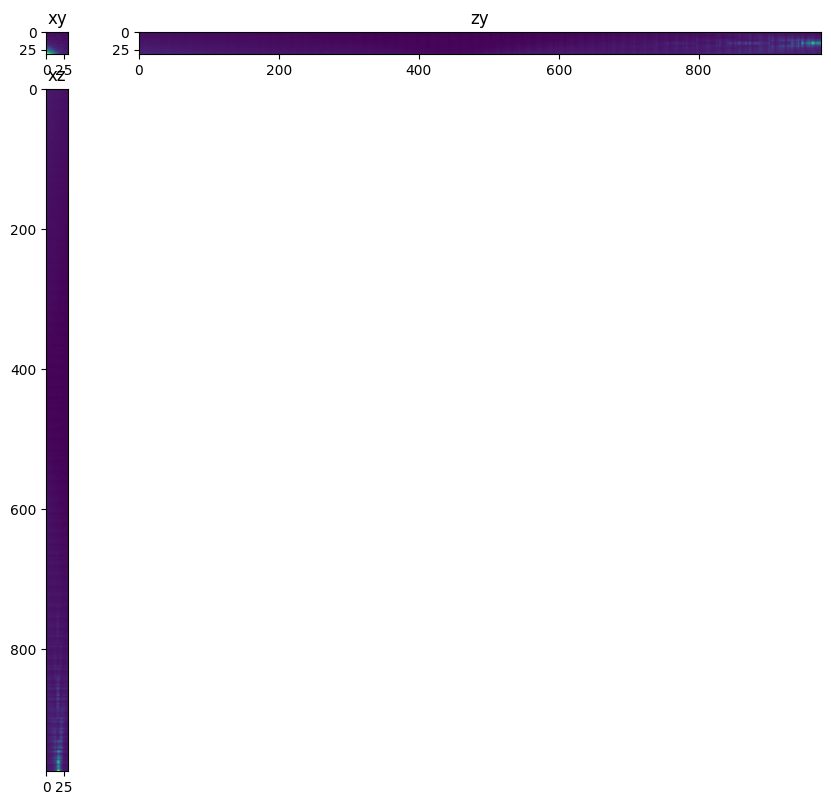

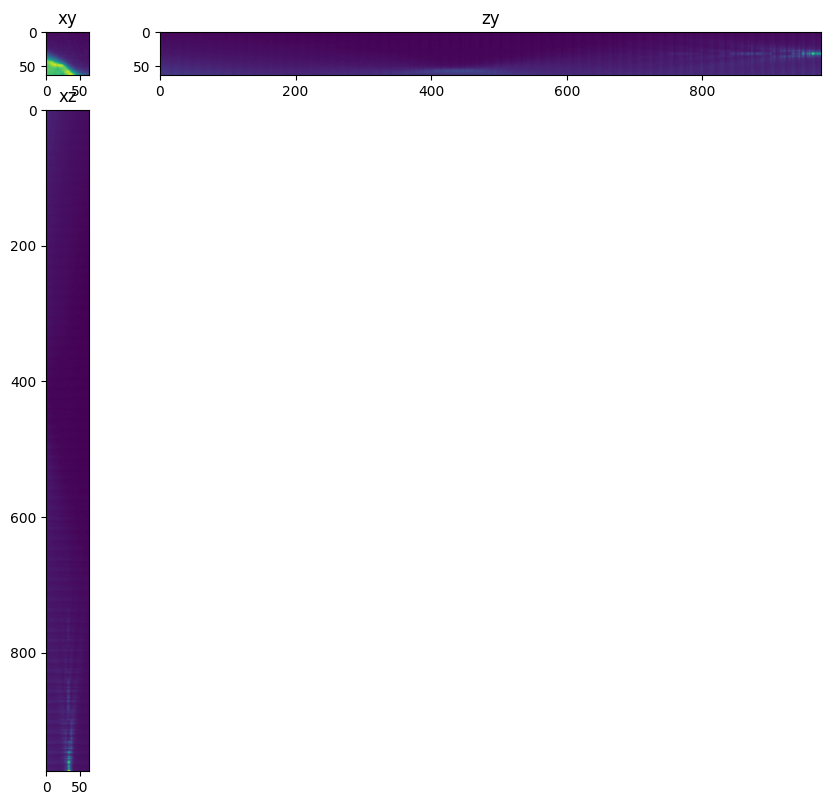

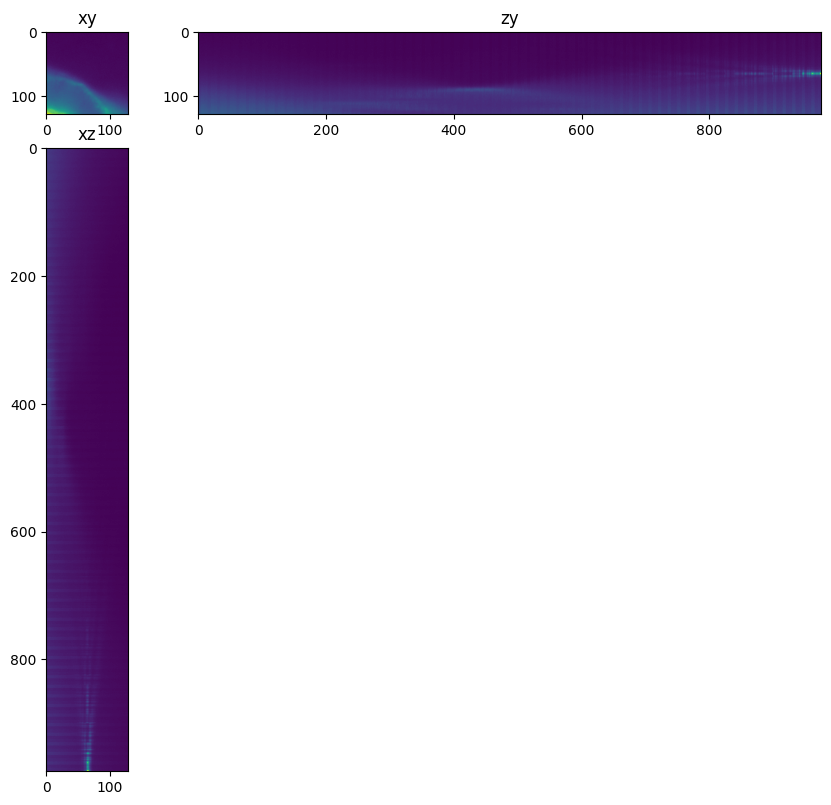

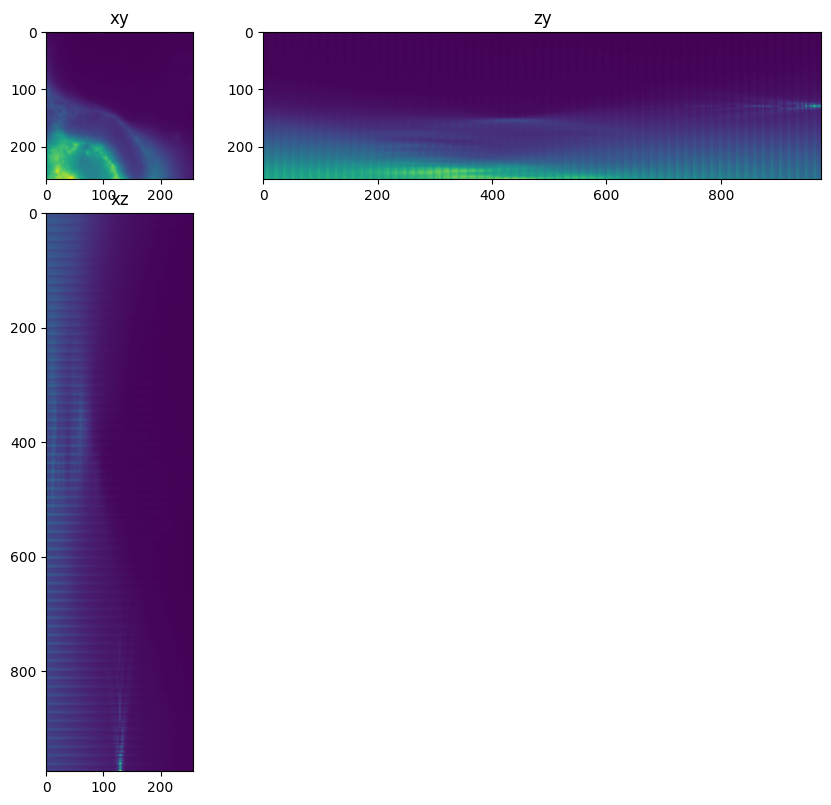

In [5]:
import mrc as Mrc
import numpy as np
from tnia.plotting.projections import show_xyz_slice_center

input_mrc = Mrc.Mrc(input_name)
input = input_mrc.data
print(input.data.shape)
print(points)
bead_num = 0 
point = points_[bead_num]

roi_dir = os.path.join(home, 'rois_'+str(bead_num))

if not os.path.exists(roi_dir):
    os.makedirs(roi_dir)

roi_names = []

print()
for size in [32, 64, 128, 256]:
    print()
    print(size)
    print('point',point)
    z, y, x = point//2
    print('z,y,x',z, y, x)
    x = int(x)
    y = int(y)
    roi = input[:, y-size//2:y+size//2, x-size//2:x+size//2]
    print('roishape',roi.shape)
    fig = show_xyz_slice_center(roi)
    
    roi_name = os.path.join(roi_dir, f'roi_{size}.mrc')
    roi_names.append(roi_name)
    Mrc.save(roi, roi_name, hdr=input_mrc.hdr, ifExists='overwrite')


In [8]:
#to_process = []


gammaApo = 0.2
suppressR = 1 
wiener = 0.001
driftfix = False 
nosuppress = False
zpadto = 0 

wl = 561 


user_text = 'gApo_'+str(gammaApo)+'_supRbase_'+str(suppressR)+'_w_'+str(wiener)+'_wl_'+str(wl)

if zpadto > 0:
    user_text += '_zpadto_'+str(zpadto)

if driftfix:
    user_text += '_driftfix'

if nosuppress:
    user_text += '_nosuppress'



## Reconstruct each ROI

In [9]:
suppressRAdjusted = suppressR
for roi_name in roi_names:
    print('Data to process ' +str(roi_name))
    base_kwargs.update(dict(gammaApo=gammaApo, suppressR=suppressRAdjusted, wiener=wiener, zpadto=zpadto))   # default Full frame Recon. parameters
    suppressRAdjusted = suppressRAdjusted * 1.5
    # Test with actually measured OTF
    sim_kwargs = dict(                                                                                                            
        input_file= roi_name,
        otf_file= otf_name,
        ls= (wl/1000)/2/0.81,)
            
    sim_kwargs.update(base_kwargs)
            
    #create processed file output name
    output_file = sim_kwargs["input_file"].replace(".mrc", '_proc'+'_' + user_text + ".mrc")
    sim_kwargs["output_file"] = output_file
    
    sim_output = simrecon(**sim_kwargs)
    print(sim_output)
    for i in range(len(sim_output)):
        sim_output[i] = sim_output[i].replace('\r', '')
    with open(output_file.replace(".mrc", ".txt"), "w") as myfile:
        myfile.write(str(sim_kwargs))
        myfile.write("\n".join(sim_output))
                

Data to process D:\Janelia\Data 2024-06-12\rois_0\roi_32.mrc
['nphases=5, ndirs=3\r', 'nx=32, ny=32, nz=65, nwaves=1, ntimes=1\r', 'nzotf=65, dkzotf=0.061538, nxotf=65, nyotf=1, dkrotf=0.060096\r', 'Number of threads used: 8\r', 'Creating FFT plans...\r', 'Separation matrix:\r', '  1.00000   1.00000   1.00000   1.00000   1.00000 \r', '  1.00000   0.30902  -0.80902  -0.80902   0.30902 \r', '  0.00000   0.95106   0.58779  -0.58779  -0.95106 \r', '  1.00000  -0.80902   0.30902   0.30902  -0.80902 \r', '  0.00000   0.58779  -0.95106   0.95106  -0.58779 \r', '\r', 'rdistcutoff = 2.905983 1/micron\r', 'k0guess[direction 0] = (0.400121, 1.387302) 1/micron\r', 'Initial guess by findk0() of k0[direction 0] = (0.095879,1.581948) 1/micron\r', 'before fitk0andmodamp\r', ' In getmodamp: angle=1.510262, mag=1.584851, amp=0.127862, phase=-0.976147\r', ' In getmodamp: angle=1.511262, mag=1.584851, amp=0.127882, phase=-0.965789\r', ' In getmodamp: angle=1.512262, mag=1.584851, amp=0.127851, phase=-0.95

## XYZ projections for each reconstruction

D:\Janelia\Data 2024-06-12\rois_0\roi_32.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_32_proc_gApo_0.2_supRbase_1_w_0.001.mrc
(65, 64, 64)
D:\Janelia\Data 2024-06-12\rois_0\roi_64.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_64_proc_gApo_0.2_supRbase_1_w_0.001.mrc
(65, 128, 128)
D:\Janelia\Data 2024-06-12\rois_0\roi_128.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_128_proc_gApo_0.2_supRbase_1_w_0.001.mrc
(65, 256, 256)
D:\Janelia\Data 2024-06-12\rois_0\roi_256.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_256_proc_gApo_0.2_supRbase_1_w_0.001.mrc
(65, 512, 512)


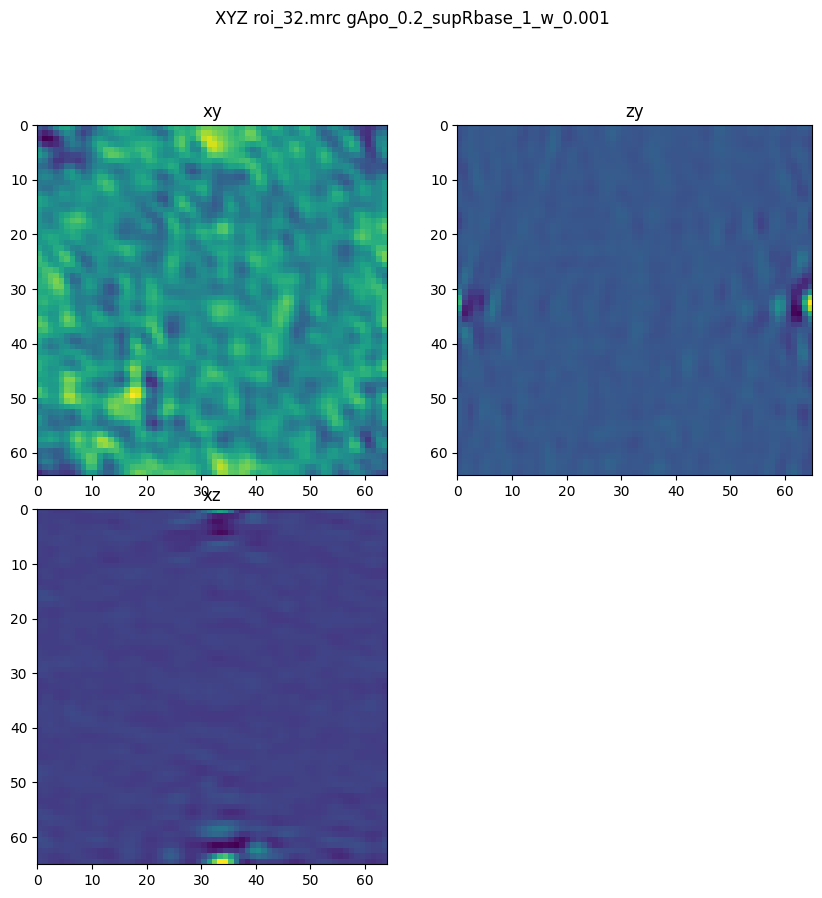

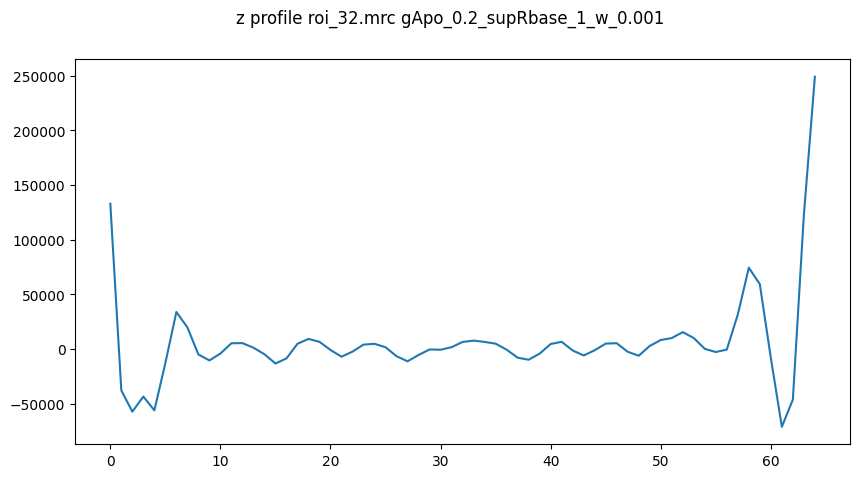

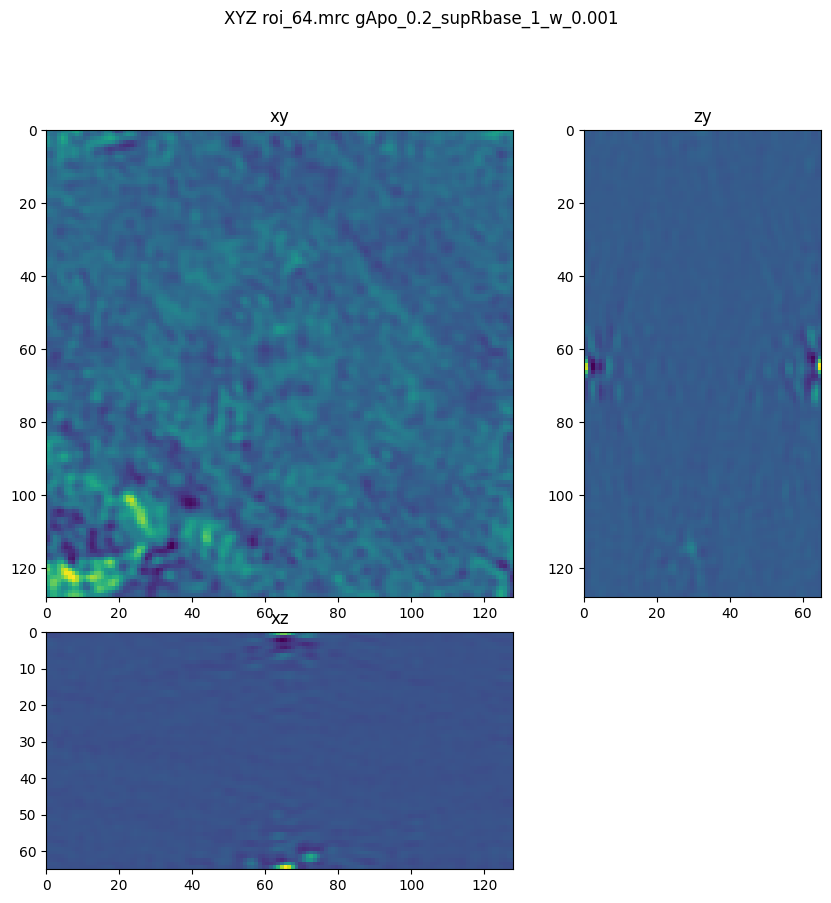

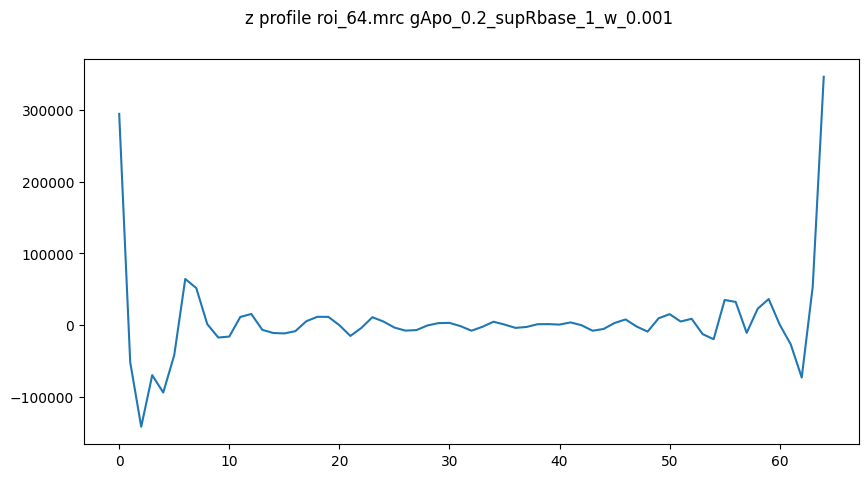

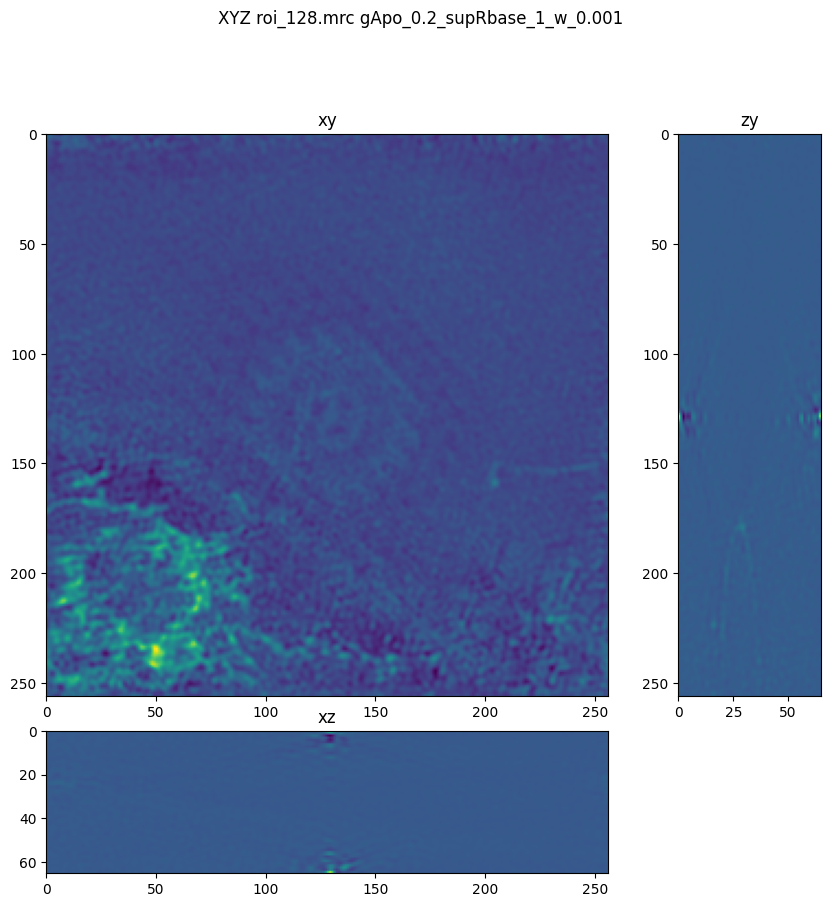

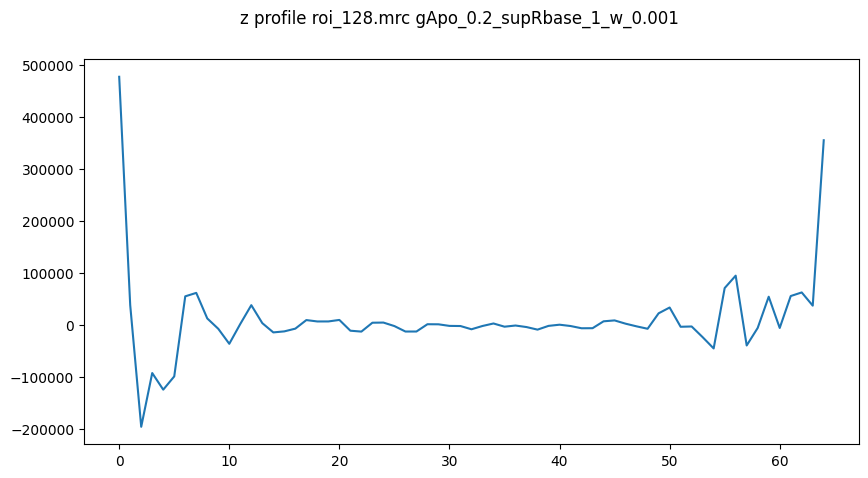

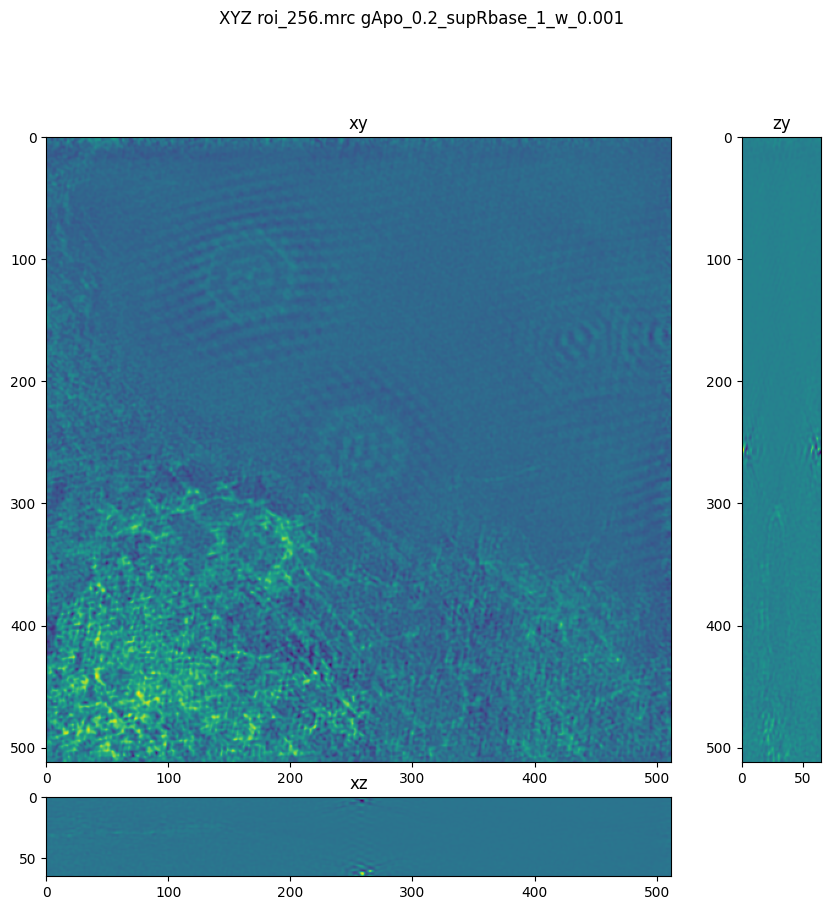

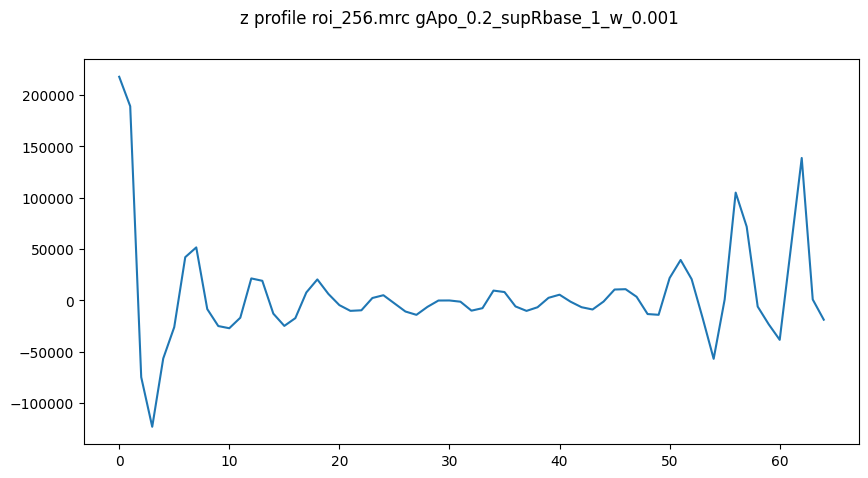

In [14]:
from tnia.plotting.projections import show_xyz_slice
import matplotlib.pyplot as plt

figure_dir = os.path.join(roi_dir, 'figures_'+user_text)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

zc = 17 

for roi_name in roi_names:
    print(roi_name)
    output_file = roi_name.replace(".mrc", '_proc'+'_' + user_text + ".mrc")
    print(output_file)
    restored = Mrc.Mrc(output_file).data
    print(restored.shape)
    
    yc, xc = restored.shape[1]//2, restored.shape[2]//2
    fig = show_xyz_slice(restored, xc, yc, zc)
    fig.suptitle('XYZ '+roi_name.split('\\')[-1] + ' ' + user_text)
    fig.savefig(os.path.join(figure_dir, roi_name.split('\\')[-1].replace('.mrc', '.png')))
    
    z_profile = restored[:,yc, xc]
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    fig.suptitle('z profile '+roi_name.split('\\')[-1] + ' ' + user_text)
    ax.plot(z_profile)

    fig.savefig(os.path.join(figure_dir, roi_name.split('\\')[-1].replace('.mrc', '_z_profile.png')))

## Plot 2d xy FFT for each reconstruction

D:\Janelia\Data 2024-06-12\rois_0\roi_32.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_32_proc_gApo_0.2_supRbase_1_w_0.001.mrc


D:\Janelia\Data 2024-06-12\rois_0\roi_64.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_64_proc_gApo_0.2_supRbase_1_w_0.001.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_128.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_128_proc_gApo_0.2_supRbase_1_w_0.001.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_256.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_256_proc_gApo_0.2_supRbase_1_w_0.001.mrc


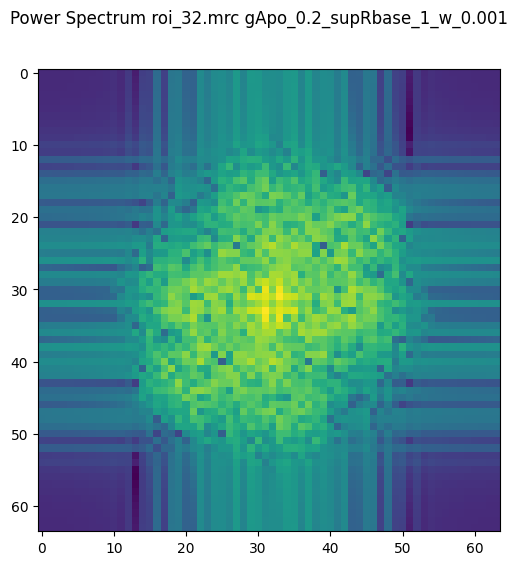

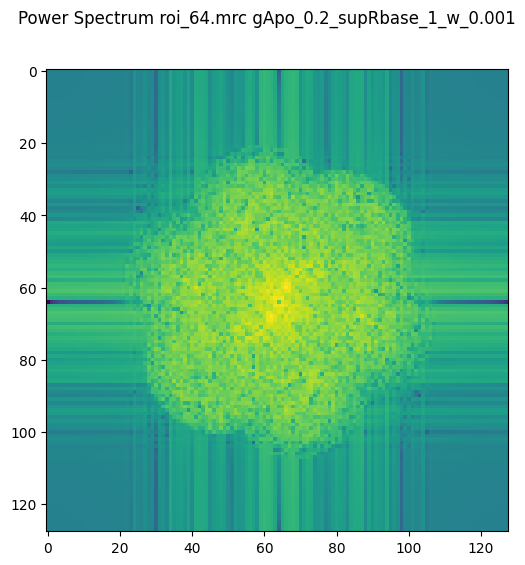

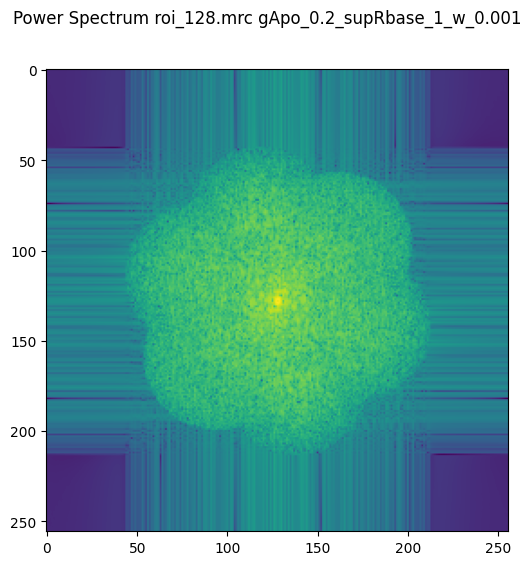

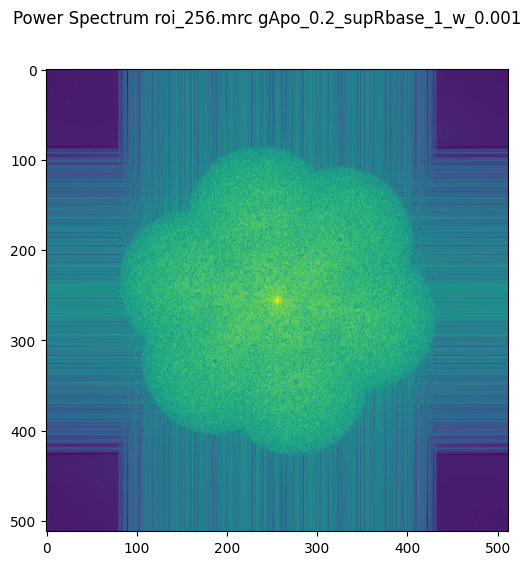

In [16]:
from scipy.fftpack import fftn, fftshift
from tnia.plotting.plt_helper import imshow2d

for roi_name in roi_names:
    print(roi_name)
    output_file = roi_name.replace(".mrc", '_proc'+'_' + user_text + ".mrc")
    print(output_file)
    restored = Mrc.Mrc(output_file).data.astype(np.float32)
    restored_2d = restored[zc,:,:]
    fft_result = fftn(restored_2d)
    fft_result_shifted = fftshift(fft_result)
    power_spectrum = np.abs(fft_result_shifted)**2
    fig = imshow2d(np.log(power_spectrum))   
    fig.suptitle('Power Spectrum '+roi_name.split('\\')[-1] + ' ' + user_text)
    fig.savefig(os.path.join(figure_dir, roi_name.split('\\')[-1].replace('.mrc', '_power_spectrum.png')))
    #zc, yc, xc = power_spectrum.shape[0]//2, power_spectrum.shape[1]//2, power_spectrum.shape[2]//2
 

## Plot 3D FFT for each reconstruction

D:\Janelia\Data 2024-06-12\rois_0\roi_32.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_32_proc_gApo_0.2_supRbase_1_w_0.001.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_64.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_64_proc_gApo_0.2_supRbase_1_w_0.001.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_128.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_128_proc_gApo_0.2_supRbase_1_w_0.001.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_256.mrc
D:\Janelia\Data 2024-06-12\rois_0\roi_256_proc_gApo_0.2_supRbase_1_w_0.001.mrc


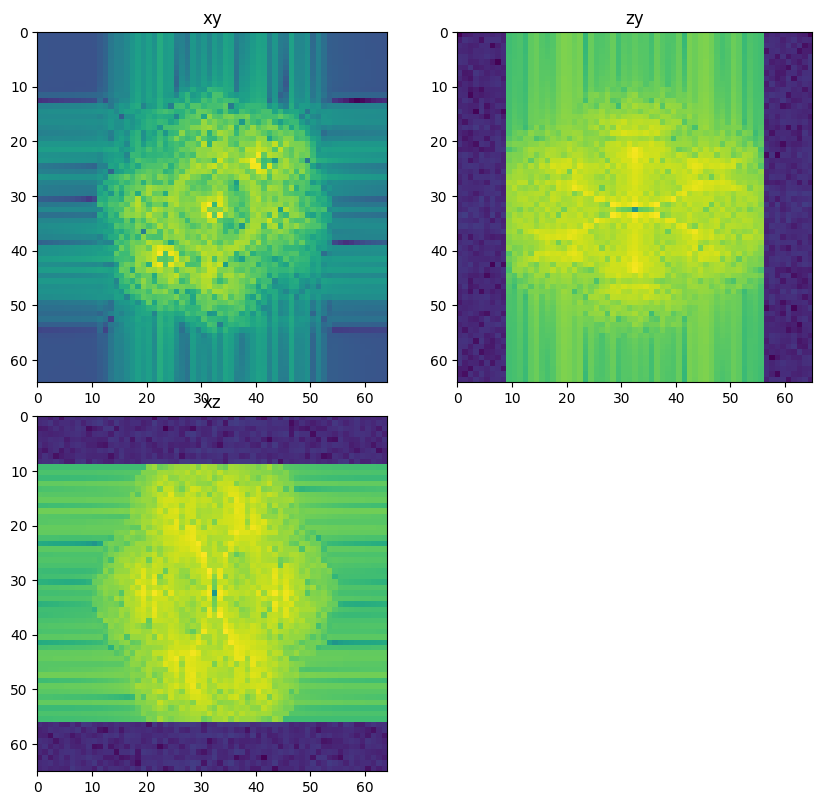

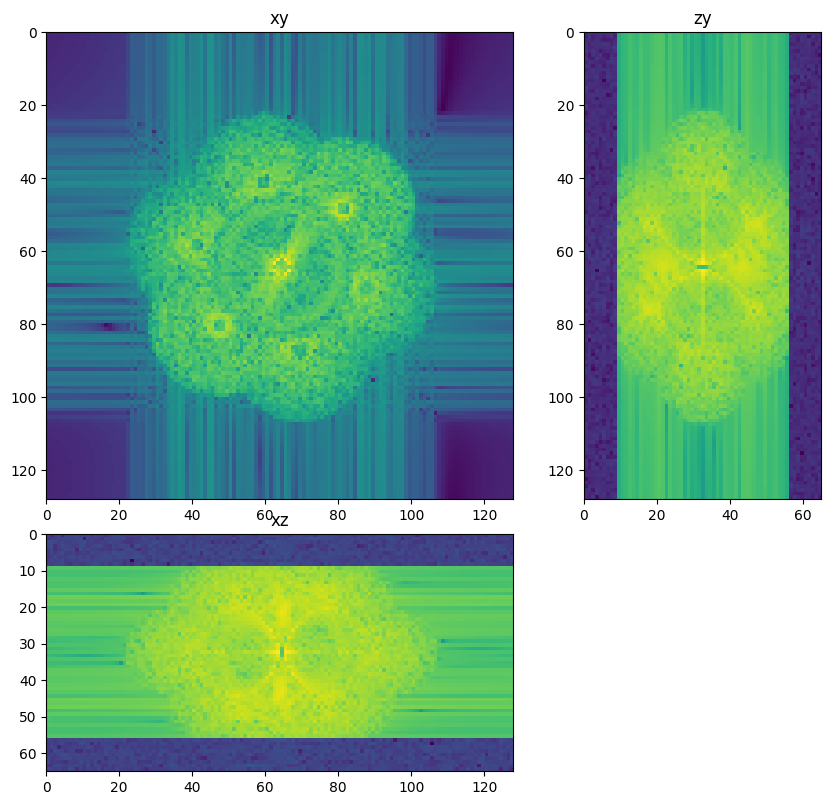

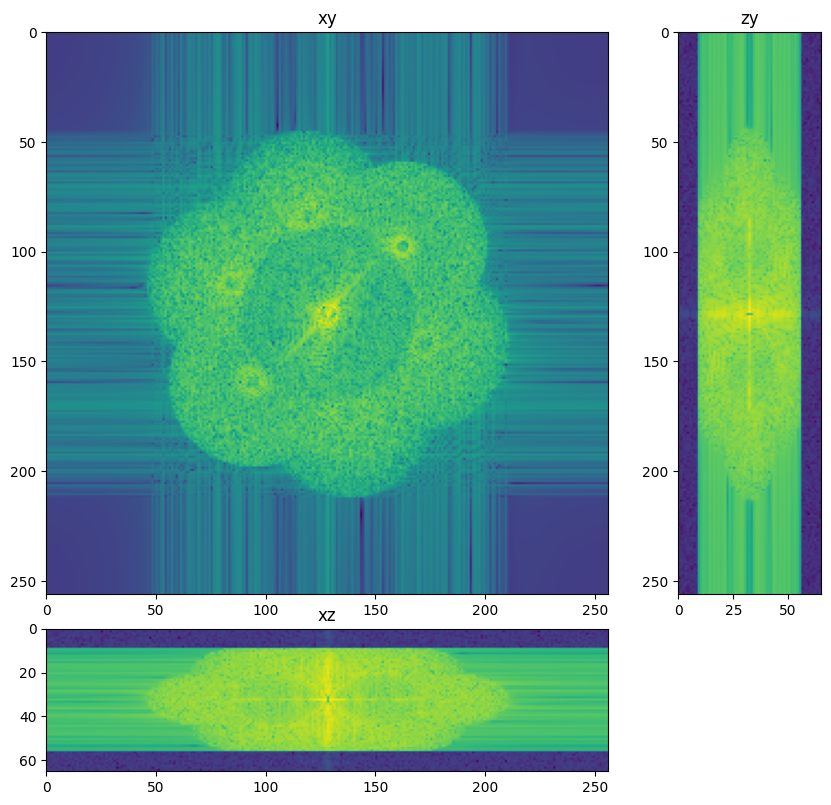

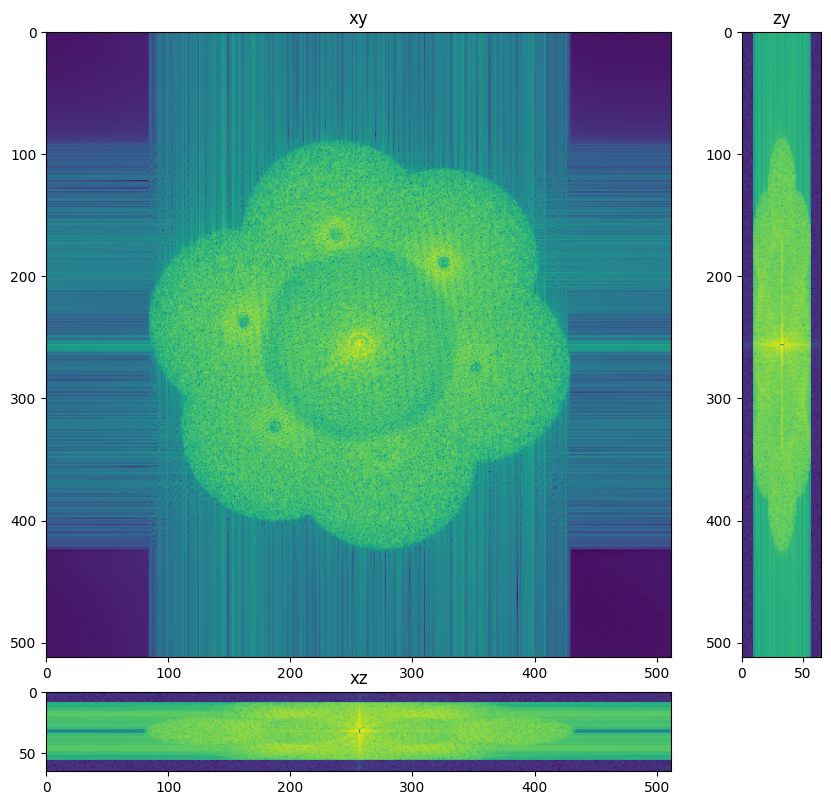

In [17]:
from scipy.fftpack import fftn, fftshift


for roi_name in roi_names:
    print(roi_name)
    output_file = roi_name.replace(".mrc", '_proc'+'_' + user_text + ".mrc")
    print(output_file)
    restored = Mrc.Mrc(output_file).data.astype(np.float32)

    fft_result = fftn(restored)
    fft_result_shifted = fftshift(fft_result)
    power_spectrum = np.abs(fft_result_shifted)**2
    power_spectrum_log = np.log(power_spectrum)
    zc, yc, xc = power_spectrum.shape[0]//2, power_spectrum.shape[1]//2, power_spectrum.shape[2]//2
    zc = 27
    fig = show_xyz_slice(power_spectrum_log, xc, yc, zc) 
 

In [11]:
import scipy